## Problem Description
<p>The company I work for heavily relies on fish resources as its major raw material. The fish are transported from all over the world to the USA. There are various types of costs associated with transportation and storage, such as demurrage, drayage, cold storage, material handling labor costs, and transportation costs to the factory. All of these costs are classified as variable overhead costs under the group named "fish handling cost," which accounts for approximately 10% of the overall conversion cost for the product. Therefore, an accurate fish handling cash flow forecast is crucial for the business operation and finance.
</p>
<p>Given the importance of accurate forecasting, this is a perfect business use case for supervised machine learning technology. Below are the steps to implement this ML solution for fish handling cash forecasting.
</p>

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

##### Load fish inventory data into Panda dataframe, total the quantity by snapshot date then convert the unit of measure to metric ton.

In [5]:
df = pd.read_excel(r'C:\Users\ilin\Downloads\OFC_1_FishInventory.xlsx')
df=df.groupby(['FiscalPeriod','FiscalPeriodWeek','SnapshotDate'],as_index=False)['TotalQty'].sum()
# df=df.to_frame() #turn searise data into DF

df=df.groupby(['FiscalPeriod','FiscalPeriodWeek'],as_index=False)['TotalQty'].mean()
df['TtlMT']=df['TotalQty']/2204.6
df.tail()
# print(df['FiscalPeriod'])

,FiscalPeriod,FiscalPeriodWeek,TotalQty,TtlMT
155,2023001,3,10099255.0,4580.992017
156,2023001,4,10170984.0,4613.528078
157,2023002,1,10146631.0,4602.481629
158,2023002,2,10713701.0,4859.702894
159,2023002,3,10835095.0,4914.766851


##### Transform the inventory data to weeks pivottable layout. this makes the beginning and ending inventory logic easy to implement.

In [6]:
df= df.pivot(index=['FiscalPeriod'],columns='FiscalPeriodWeek',values='TtlMT')
# df= df.mean()


In [7]:
df.head()

FiscalPeriodWeek,1,2,3,4,5
FiscalPeriod,,,,,
2020001,3049.027488,3536.496417,3103.600200,3121.676495,NaN
2020002,3119.687925,2695.267169,2359.744625,2057.421301,NaN
2020003,2316.350812,2441.844779,2053.261816,2105.208201,2035.600109
2020004,2542.743355,NaN,2694.276966,2708.263631,NaN
2020005,2941.140797,2150.299828,2207.898485,2367.375941,NaN


##### Beginning and Ending Inventory Calculation. Column 1 is beginning inventory, and column 4 is the ending, if column 5 is empty.

In [8]:
df['BegInv']=df[1]
df['EndInv'] = df.apply(lambda x: x[5] if x[5] > 0 else x[4], axis=1)
df_Inv=df
df_Inv.head()

FiscalPeriodWeek,1,2,3,4,5,BegInv,EndInv
FiscalPeriod,,,,,,,
2020001,3049.027488,3536.496417,3103.600200,3121.676495,NaN,3049.027488,3121.676495
2020002,3119.687925,2695.267169,2359.744625,2057.421301,NaN,3119.687925,2057.421301
2020003,2316.350812,2441.844779,2053.261816,2105.208201,2035.600109,2316.350812,2035.600109
2020004,2542.743355,NaN,2694.276966,2708.263631,NaN,2542.743355,2708.263631
2020005,2941.140797,2150.299828,2207.898485,2367.375941,NaN,2941.140797,2367.375941


##### Load Invoice and payment data that was downloaded from the data warehouse. Three years'  data was saved into three excel files. 

In [9]:
files = [r'C:\Users\ilin\Downloads\OFC_2_2022Payment.xlsx',
         r'C:\Users\ilin\Downloads\OFC_3_2021Payment.xlsx',
         r'C:\Users\ilin\Downloads\OFC_4_2023Payment.xlsx']

df_Pmt = pd.concat([pd.read_excel(f) for f in files])
df_Pmt = df_Pmt.dropna(subset=['Text'])
df_Pmt = df_Pmt[df_Pmt['Text'].str.contains("Accrual") & (df_Pmt['Amount in local cur.'] > 0)]
df_Pmt.head()

,DocumentNo,Account,CoCd,Profit Ctr,Vendor Name,User name,Text,Reference,Pstng Date,Amount in local cur.
122,102456920,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P1,840111,2022-01-29,164004.46
231,102461654,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P2,840210,2022-02-25,219597.91
295,102484392,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P3,840314,2022-04-01,283188.20
413,102486705,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P4,840406,2022-04-29,466399.35
513,102492506,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P5,840507,2022-05-27,595096.53


In [10]:
Cal = pd.read_excel(r'C:\Users\ilin\Downloads\MasterCalendar.xlsx')

In [11]:
df_Pmt = df_Pmt.merge(Cal, left_on='Pstng Date', right_on='Date', how='left')
df_Pmt.head()

,DocumentNo,Account,CoCd,Profit Ctr,Vendor Name,User name,Text,Reference,Pstng Date,Amount in local cur.,Date,WeekNumber,Quarter,Period,PeriodWeek,FiscPd,PDIndex,FiscWkNum
0,102456920,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P1,840111,2022-01-29,164004.46,2022-01-29,4,1,1,4,2022001,169,4
1,102461654,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P2,840210,2022-02-25,219597.91,2022-02-25,8,1,2,4,2022002,170,8
2,102484392,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P3,840314,2022-04-01,283188.20,2022-04-01,13,1,3,5,2022003,171,13
3,102486705,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P4,840406,2022-04-29,466399.35,2022-04-29,17,2,4,4,2022004,172,17
4,102492506,540474,1001,11000,NaN,SGOMEZ,OFC Accrual P5,840507,2022-05-27,595096.53,2022-05-27,21,2,5,4,2022005,173,21


In [12]:
df_Pmt=df_Pmt[['FiscPd','Amount in local cur.']]
df_Pmt.head()

,FiscPd,Amount in local cur.
0,2022001,164004.46
1,2022002,219597.91
2,2022003,283188.20
3,2022004,466399.35
4,2022005,595096.53


##### Load fish movements data that is downloaded from the data warehouse.

In [13]:
df_Fishmove = pd.read_excel(r'C:\Users\ilin\Downloads\OFC_5_LoinMoves.xlsx')
df_Fishmove=df_Fishmove[['Fiscal Period','Quantity','Unit of Measure']]
df_Fishmove

,Fiscal Period,Quantity,Unit of Measure
0,2021007,-2731.499,LB
1,2021007,-2821.888,LB
2,2021007,-2696.226,LB
3,2020001,-1.000,LB
4,2020005,-2563.950,LB
...,...,...,...
108040,2022012,2623.474,LB
108041,2022012,2623.474,LB
108042,2022012,2623.474,LB
108043,2022012,2623.474,LB


##### FIsh movement is aggerated to fiscal period level in metric tons.

In [14]:
df_Fishmove['Quantity']= df_Fishmove.apply(lambda x: x['Quantity']/2204.6 if x['Unit of Measure'] =='LB' else x['Quantity'], axis=1)
df_Fishmove=df_Fishmove.groupby(['Fiscal Period'],as_index=False)['Quantity'].sum()
df_Fishmove.head()

,Fiscal Period,Quantity
0,2020001,1157.993992
1,2020002,1868.092002
2,2020003,1617.028000
3,2020004,1440.304001
4,2020005,1340.953000


##### Load production volume data into data frame

In [15]:
df_Prd = pd.read_excel(r'C:\Users\ilin\Downloads\OFC_6_Production.xlsx')
df_Prd.head()

,Row Labels,ActStdCases
0,2020001,656337
1,2020002,641157
2,2020003,861286
3,2020004,739870
4,2020005,720804


##### Final dataset- merge all the datasets from above into one flat table

In [16]:
df_Inv = df.reset_index()
df = df_Inv[['FiscalPeriod','BegInv','EndInv']].set_index('FiscalPeriod')

df=df.merge(df_Pmt, left_on='FiscalPeriod', right_on='FiscPd', how='inner')
df=df.merge(df_Fishmove, left_on='FiscPd', right_on='Fiscal Period', how='left')
df=df.merge(df_Prd, left_on='FiscPd', right_on='Row Labels', how='left')
df=df[['Fiscal Period','BegInv','EndInv','Amount in local cur.','Quantity','ActStdCases']]
df.columns=['Fiscal Period','BegInv','EndInv','Payment','MoveQty','StdCases']
df

,Fiscal Period,BegInv,EndInv,Payment,MoveQty,StdCases
0,2020001,3049.027488,3121.676495,248997.6875,1157.993992,656337
1,2020002,3119.687925,2057.421301,195793.5625,1868.092002,641157
2,2020003,2316.350812,2035.600109,196274.8750,1617.028000,861286
3,2020004,2542.743355,2708.263631,225112.6250,1440.304001,739870
4,2020005,2941.140797,2367.375941,164517.5000,1340.953000,720804
5,2020006,2257.172730,2324.720131,148223.3125,2812.023000,898687
6,2020007,2462.876259,2185.432732,166606.5000,1793.322997,803303
7,2020008,2054.334120,3052.189966,98266.3125,2594.762996,715746
8,2020009,2595.529801,3631.802141,156807.6000,3228.350463,563627
9,2020010,4735.140161,6430.830083,130545.9375,2510.659999,332092


In [17]:
df.describe()

,Fiscal Period,BegInv,EndInv,Payment,MoveQty,StdCases
count,3.800000e+01,38.000000,38.000000,38.000000,38.000000,38.000000
mean,2.021059e+06,3989.095969,3920.554081,248927.609934,1809.302956,579109.657895
std,8.679555e+02,1478.608146,1441.455640,120424.917318,694.331871,172426.593177
min,2.020001e+06,1742.885331,1943.698630,98266.312500,491.992000,227660.000000
25%,2.020010e+06,3032.329561,3069.561598,165039.750000,1309.918749,454248.250000
50%,2.021006e+06,3530.015876,3613.978046,226023.407500,1688.864501,573646.000000
75%,2.022004e+06,4712.893836,4753.111222,286292.965625,2316.269749,703565.000000
max,2.023001e+06,7948.460945,7877.798240,605552.120000,3608.242001,987564.000000


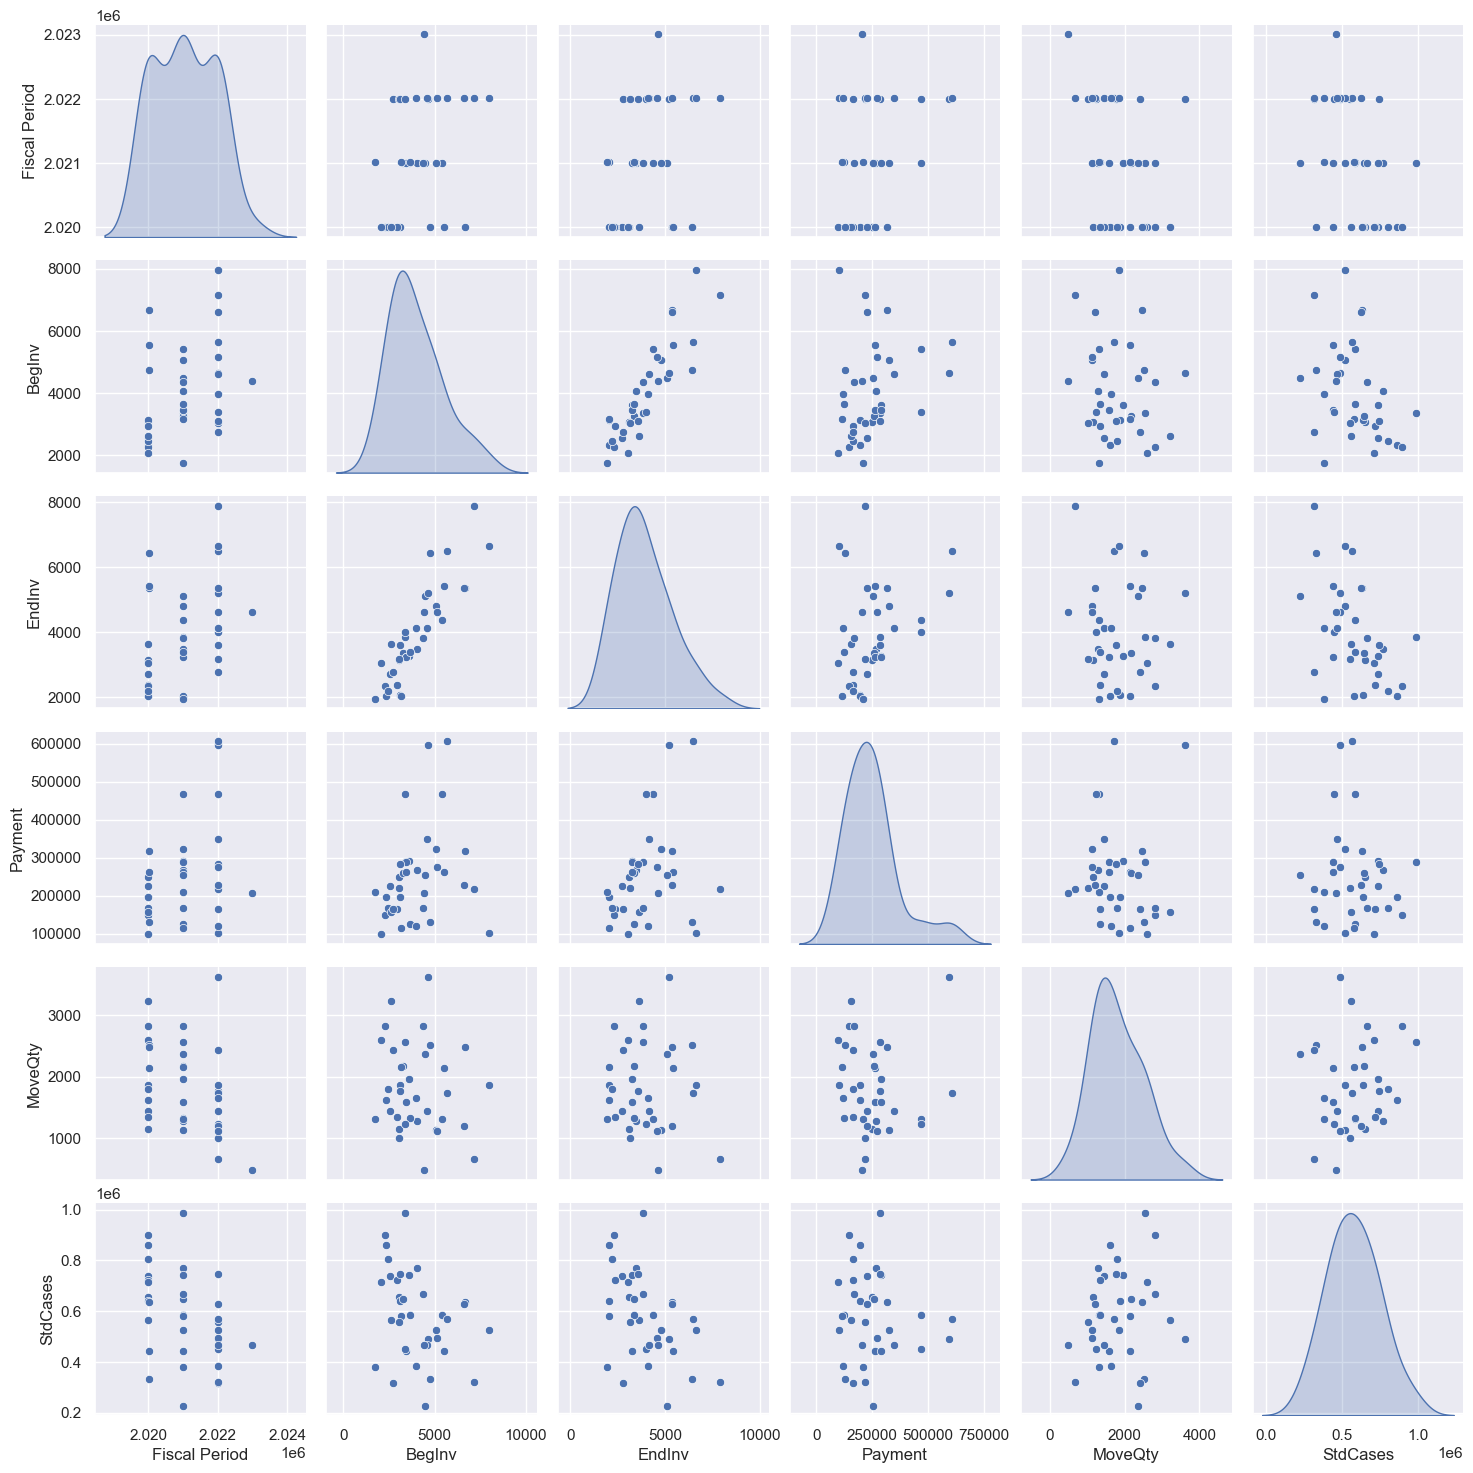

In [16]:
df.corr()
sns.pairplot(df, diag_kind = 'kde')
plt.savefig('pair_plot.png', dpi = 300, bbox_inches = 'tight')

In [18]:
model= smf.ols(formula= 'Payment~BegInv + EndInv + MoveQty+StdCases ', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Payment   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.012
Date:                Sat, 25 Feb 2023   Prob (F-statistic):              0.415
Time:                        00:15:57   Log-Likelihood:                -495.77
No. Observations:                  38   AIC:                             1002.
Df Residuals:                      33   BIC:                             1010.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.862e+04   1.25e+05      0.791      0.435   -1.55e+05    3.52e+05
BegInv        -8.9613     30.164     -0.297      0.768     -70.330      52.407
EndInv        38.3806     32.533      1.180      0.247     -27.808     104.570
MoveQty       -2.0636     29.913     -0.069      0.945     -62.923      58.795
StdCases       0.0679      0.133      0.510      0.613      -0.203       0.339
==============================================================================
Omnibus:                        7.609   Durbin-Watson:                   1.122
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.266
Skew:                           0.846   Prob(JB):                       0.0436
Kurtosis:                       4.046   Cond. No.                     3.85e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X=df[['BegInv','EndInv','MoveQty','StdCases']]
y=df['Payment']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
r2=[]
l=[]
for i in range(1,20):
    poly = PolynomialFeatures(degree=i)
    X_poly = poly.fit_transform(X)

    # Fit linear regression model
    reg = LinearRegression().fit(X_poly, y)
    y_pred = reg.predict(X_poly)
    r2.append(metrics.r2_score(y, y_pred))
    l.append(i)
# print("Accuracy of the model:", metrics.r2_score(y, y_pred))

0.9994176077541682


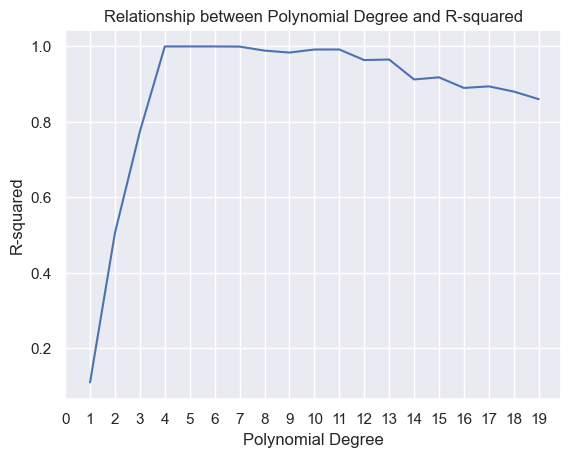

In [20]:
print(max(r2))
fig, ax = plt.subplots()
ax.plot(l,r2)
# plt.plot(l,r2) 
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.title('Relationship between Polynomial Degree and R-squared')
ax.set_xticks(np.arange(0, 20, 1))
plt.show()
 

In [21]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Fit linear regression model
reg_yes = LinearRegression().fit(X_poly, y)
y_pred = reg_yes.predict(X_poly)
print("Accuracy of the model:", metrics.r2_score(y, y_pred))

Accuracy of the model: 0.7743487239098648


In [22]:
# New data for which predictions are to be made
new_data = pd.DataFrame({'BegInv': [4250], 'EndInv': [4250], 
                        'MoveQty': [1862], 'StdCases': [516576]})

# new_data = pd.DataFrame({'BegInv': [12350], 'EndInv': [11940], 
#                         'MoveQty': [1312], 'StdCases': [584822]})

# Make predictions on new data
new_data_poly = poly.transform(new_data)
predictions = reg_yes.predict(new_data_poly)

print("Predictions:", predictions)

Predictions: [272037.66703666]


In [61]:
df.to_csv('/Users/ilin/Downloads/SFSOFC.txt',sep='\t',index=False) #, encoding='utf-8'

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()

In [40]:
rf_train=rf.fit(X, y)
rf_pred=rf.predict(X)
print("Accuracy of the model:", metrics.r2_score(y, rf_pred))

Accuracy of the model: 0.8261013602731134


In [41]:
# New data for which predictions are to be made
new_data = pd.DataFrame({'BegInv': [4250], 'EndInv': [4220], 
                        'MoveQty': [1862], 'StdCases': [526576]})

# new_data = pd.DataFrame({'BegInv': [12350], 'EndInv': [11940], 
#                         'MoveQty': [1312], 'StdCases': [584822]})

# Make predictions on new data
predictions = rf.predict(new_data)

print("Predictions:", predictions)

Predictions: [250284.57195833]


In [42]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()

# fit the model on the training data
ada.fit(X,y)
ada_pred=ada.predict(X)
print("Accuracy of the model:", metrics.r2_score(y, ada_pred))

Accuracy of the model: 0.8731009548456359


In [43]:
predictions = ada.predict(new_data)

print("Predictions:", predictions)

Predictions: [206039.49]
